# TensorBoard

## Dependencies

Note: the following dependencies were **not included** in the project's requirements file:
* tensorflow
* tensorboard
* torch

In [1]:
# Load in the used dependencies
import os
import numpy as np
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data

### Hyperparameters

In [3]:
LOG_DIR = './population_backup/storage/experiment6/data_neat/'
topology_id = 3
overwrite = True
rm_duplicates = False  # Remove all samples with at least 'dup_columns' duplicate values
dup_columns = 5  # Number of duplicated columns a single sample has before removal
perfect_score = True  # Filter to only contain samples that solve the problem

### Fetch

In [5]:
# Setup the header
head = ["fitness",
        'bias_r', 'bias_z', 'bias_h',
        'weight_xr', 'weight_xz', 'weight_xh',
        'weight_hr', 'weight_hz', 'weight_hh']
if topology_id == 1:
    head += ['conn1', 'conn2']
elif topology_id == 2:
    head += ['base_rw', 'conn2']
elif topology_id in [3]:
    head += ['bias_rw', 'conn0', 'conn1', 'conn2']
else: 
    raise Exception(f"Topology-ID {topology_id} not supported!")

In [6]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_{topology_id}_0.csv')
data_path = os.path.join(LOG_DIR, f'data_{topology_id}.tsv')
meta_path = os.path.join(LOG_DIR, f'meta_{topology_id}.tsv')

# Load in the data (without header)
if not overwrite and os.path.exists(data_path):
    data = np.genfromtxt(data_path, delimiter='\t')
    meta = np.genfromtxt(meta_path, delimiter='\t')
else:
    raw = np.genfromtxt(raw_path, delimiter=',')[1:]
    data = raw[:,:-1]
    meta = raw[:,-1]
    np.savetxt(data_path, data, delimiter='\t')
    np.savetxt(meta_path, meta, delimiter='\t')

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (2373, 13)
Meta shape: (2373,)


In [7]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head[1:])
meta_pd = pd.DataFrame(meta, columns=head[:1])

In [8]:
data_pd.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2
0,1.250919,2.055688,0.398318,-0.760170,-0.558187,1.052576,1.106443,-1.693040,-2.265292,1.354561,-3.431134,-5.673531,-4.650152
1,1.140806,2.055688,0.398318,-1.441832,-0.168766,0.933514,0.642983,-1.736059,-2.417454,1.354561,-3.900162,-5.745558,-4.650152
2,0.164919,2.055688,0.398318,-1.441832,-0.168766,1.052576,0.642983,-1.753808,-2.361880,1.354561,-3.693642,-5.316225,-5.061747
3,-0.096472,2.055688,0.398318,-1.441832,-0.168766,1.052576,0.642983,-1.753808,-2.361880,1.354561,-3.693642,-5.316225,-5.061747
4,1.140806,2.055688,0.398318,-1.441832,-0.168766,0.933514,0.642983,-1.736059,-2.417454,1.354561,-3.900162,-5.745558,-4.650152


In [9]:
meta_pd.head()

,fitness
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


### Filter the data

In [10]:
# Filter out the complete duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (1801, 13)
Meta shape: (1801, 1)


In [11]:
# For example, if you want to see only fitnesses of 1 (perfect score).
if perfect_score:
    indices = meta_pd == 1
    data_pd = data_pd[indices.values]
    meta_pd = meta_pd[indices.values]
    print(f"Data shape: {data_pd.shape}")
    print(f"Meta shape: {meta_pd.shape}")

Data shape: (1801, 13)
Meta shape: (1801, 1)


In [12]:
# Filter out all the samples that have at least one duplicate value (in each of its columns)
if rm_duplicates:
    indices = (meta_pd<0).astype(int).values.flatten()  # Little hack
    for h in head[1:]:
        indices += data_pd.duplicated(subset=h).astype(int).values

    # Remove all that exceed the set threshold
    data_pd = data_pd[indices < dup_columns]
    meta_pd = meta_pd[indices < dup_columns]
    print(f"Dropping duplicates that occur in {dup_columns} columns or more")
    print(f" > Data shape: {data_pd.shape}")
    print(f" > Meta shape: {meta_pd.shape}")

In [13]:
data_pd

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2
0,1.250919,2.055688,0.398318,-0.760170,-0.558187,1.052576,1.106443,-1.693040,-2.265292,1.354561,-3.431134,-5.673531,-4.650152
1,1.140806,2.055688,0.398318,-1.441832,-0.168766,0.933514,0.642983,-1.736059,-2.417454,1.354561,-3.900162,-5.745558,-4.650152
2,0.164919,2.055688,0.398318,-1.441832,-0.168766,1.052576,0.642983,-1.753808,-2.361880,1.354561,-3.693642,-5.316225,-5.061747
3,-0.096472,2.055688,0.398318,-1.441832,-0.168766,1.052576,0.642983,-1.753808,-2.361880,1.354561,-3.693642,-5.316225,-5.061747
5,0.164919,2.055688,0.398318,-1.183003,-0.168766,1.052576,0.642983,-1.753808,-2.361880,1.354561,-3.693642,-5.316225,-5.061747
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,-0.505357,1.762239,-0.388162,0.454014,0.405528,-0.684179,-1.355360,1.641569,0.971295,1.386533,-4.185253,1.709447,-3.579088
2369,-0.505357,1.762239,-0.388162,0.311086,0.338632,-0.684179,-1.355360,1.389720,0.821728,1.386533,-4.185253,1.709447,-3.579088
2370,-0.505357,1.762239,-0.388162,0.281065,0.338632,-0.684179,-1.577169,1.641569,0.971295,1.386533,-4.185253,1.709447,-3.579088
2371,-0.505357,1.762239,-0.388162,0.233293,0.338632,-0.684179,-1.260118,1.641569,0.956669,1.386533,-4.185253,1.709447,-3.579088


### Visualize the data

Remark: Symmetry in data clearly by conn1 (this is the connection between GRU node and output of the global network) 

In [67]:
def adapt_and_show(data, indices=None):
    data_temp = data
    if indices is not None: data_temp = data_temp[indices.values]
    print(f"Size: {data_temp.shape}")
    plt.figure(figsize=(15,5))
    for i, h in enumerate(head[1:]):
        plt.subplot(int(len(head)/6+1),6,i+1)
        sns.violinplot(data_temp[h])
        plt.title(h)
        if 'bias' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
    plt.tight_layout()
    plt.show()
    plt.close()

Size: (591, 13)


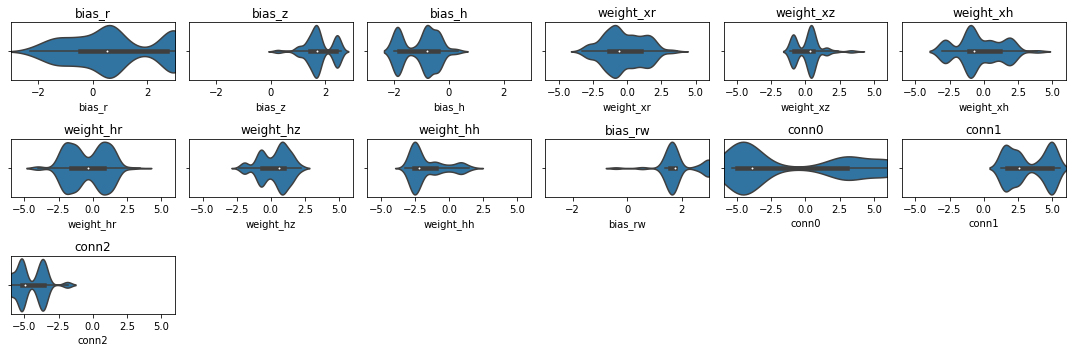

In [68]:
indices = (data_pd['conn1'] > 0)
adapt_and_show(data_pd, indices)

Size: (243, 13)


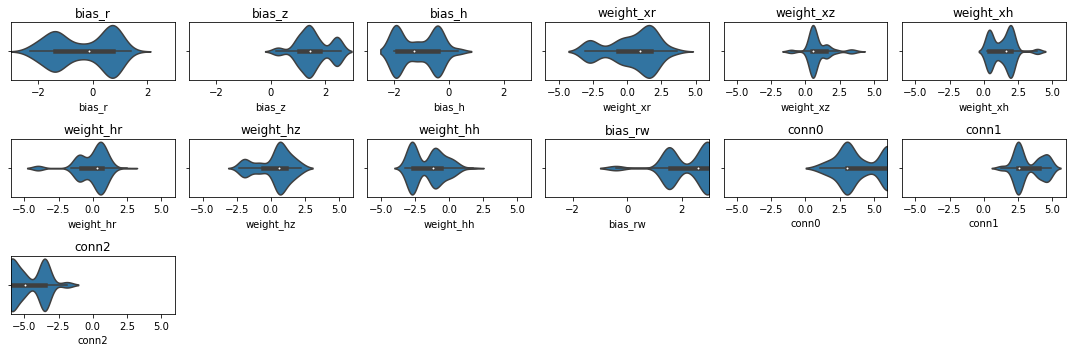

In [69]:
indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0)
adapt_and_show(data_pd, indices)

Size: (116, 13)


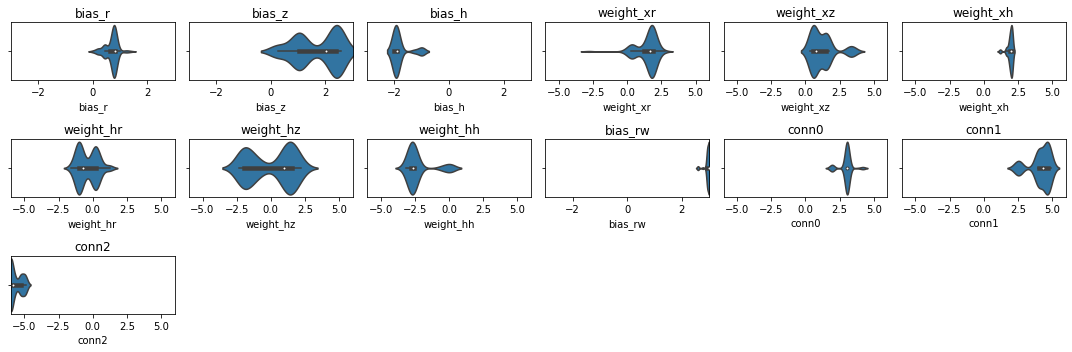

In [73]:
indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0) & (data_pd['bias_r'] > 0)
adapt_and_show(data_pd, indices)

Size: (127, 13)


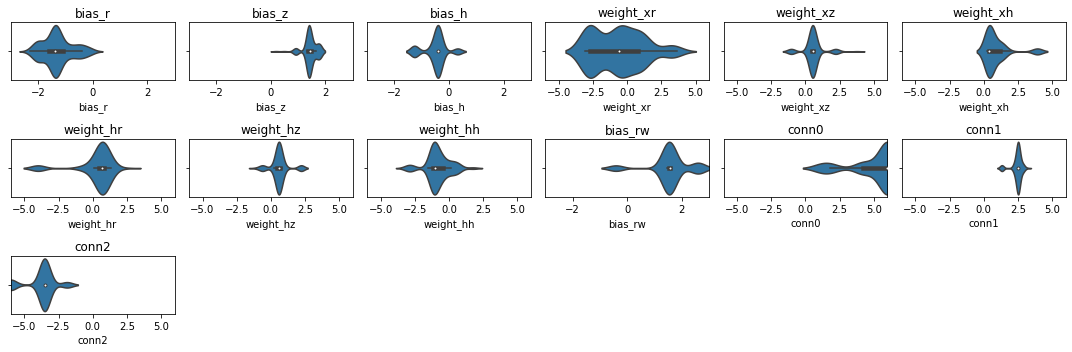

In [71]:
indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0) & (data_pd['bias_r'] < 0)
adapt_and_show(data_pd, indices)

### Format

Create labels for visualisation.

In [20]:
# Create better labels
meta_str = []
for d, m in zip(data_pd.values, meta_pd.values):
    s = [str(round(m[0], 2))]
    s += [str(round(x, 5)) for x in d]
    meta_str.append(s)   

# Example
print(f"Data example: \n> {data_pd.values[0]}")
print(f"Label example: \n> {meta_str[0]}")
print(f"For header: \n> {head}")

Data example: 
> [ 1.25091922  2.0556875   0.39831827 -0.76017035 -0.55818742  1.05257562
  1.1064429  -1.69304014 -2.26529199  1.35456084 -3.4311341  -5.67353117
 -4.6501516 ]
Label example: 
> ['1.0', '1.25092', '2.05569', '0.39832', '-0.76017', '-0.55819', '1.05258', '1.10644', '-1.69304', '-2.26529', '1.35456', '-3.43113', '-5.67353', '-4.65015']
For header: 
> ['fitness', 'bias_r', 'bias_z', 'bias_h', 'weight_xr', 'weight_xz', 'weight_xh', 'weight_hr', 'weight_hz', 'weight_hh', 'bias_rw', 'conn0', 'conn1', 'conn2']


## Magic

Folder in which data is stored is "runs/topology_1" (always keep "runs"). Change this is you want to compare several configurations.

In [21]:
# Fire up the TensorBoard
writer = SummaryWriter(log_dir=f"runs/topology_{topology_id}")  # Overwrites if already exists
writer.add_embedding(data_pd.to_numpy(), meta_str, metadata_header=head)
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

# Tensorboard can be opened in separate tab: localhost:6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 11936.